## Timings test
We will compare the timings and confidence intervals of the foostrap library against the Scipy bootstrap.

The cases to be compared are:
1. 2-sample mean difference for dense data, without parallelism
2. 2-sample mean difference for dense data, with parallelism (default unless specified)
3. 2-sample mean difference for sparse data
4. 2-sample mean difference for binary data
5. 1-sample standard deviation for dense data
6. 1-sample standard deviation for sparse data
7. 1-sample 90% percentile for dense data
8. 1-sample 90% percentile for sparse data
9. 2-sample ratio of sums difference
10. 2-sample weighted mean difference
11. 1-sample pearson correlation

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import bootstrap
import matplotlib.pyplot as plt
from foostrap import foostrap

#### Generate data for the different cases

In [2]:
n1 = 1000 # Sample size 1
n2 = 1000 # Sample size 2
prob_1 = 0.22 # Proportion of non-zeros on x1
prob_2 = 0.2 # Proportion of non-zeros on x2
sigma = 2.0 # Lognormal scale parameter
n_boots = 100000 # Bootstrap samples

rng = np.random.Generator(np.random.SFC64(0))
nnz1 = int(prob_1 * n1)
nnz2 = int(prob_2 * n2)
nz1 = n1 - nnz1
nz2 = n2 - nnz2

# Sparse 1D arrays for mean, std and quantile statistic
x = np.concatenate((np.zeros(nz1), rng.lognormal(sigma= sigma, size= nnz1) + 0.2))
y = np.concatenate((np.zeros(nz2), rng.lognormal(sigma= sigma, size= nnz2)))

# Binary 1D arrays for mean, std statistic
xb = 1*(x != 0)
yb = 1*(y != 0)

# 2D arrays for ratio and weighted mean statistic
z = np.concatenate((x.reshape(-1,1), rng.lognormal(sigma= sigma, size= (n1,1))), axis= 1)
w = np.concatenate((y.reshape(-1,1), rng.lognormal(sigma= sigma, size= (n2,1))), axis= 1)

# 2D correlated array for pearson correlation statistic
xc = np.concatenate((x.reshape(-1,1), x.reshape(-1,1) * rng.lognormal(sigma= sigma/2, size= (n1,1))), axis= 1)
res = pd.DataFrame(columns= ['lib','stat','inputs','density (foostrap)','parallel (foostrap)','avg time','ci lo','ci up','samples']) # results

#### Statistic functions for the Scipy bootstrap

In [3]:
def mean_dif(x, y, axis= -1):
    return np.mean(x, axis= axis) - np.mean(y, axis= axis)
def quant(x, axis= -1):
    return np.quantile(x, 0.9, axis= axis)
def ratio_dif(x, y, axis= -1):
    return x[0].sum(axis= axis) / x[1].sum(axis= axis) - y[0].sum(axis= axis) / y[1].sum(axis= axis)
def wmean_dif(x, y, axis= -1):
    return x.prod(axis= 0, keepdims= True).sum(axis= axis).squeeze() / x[1].sum(axis= axis) - y.prod(axis= 0, keepdims= True).sum(axis= axis).squeeze() / y[1].sum(axis= axis)
def pearson(x, y):
    return np.corrcoef(x,y)[0,1]

### Run all tests
This takes around 10 minutes

In [4]:
print('    scipy mean difference')
bootres = bootstrap((x,y), mean_dif, vectorized= True, random_state= rng, batch= 1000, n_resamples= n_boots)
times = %timeit -r 10 -o bootstrap((x,y), mean_dif, vectorized= True, random_state= rng, batch= 1000, n_resamples= n_boots)
res.loc[len(res)] = ('scipy','mean diff',2,'dense',False,times.average,bootres.confidence_interval.low,bootres.confidence_interval.high,bootres.bootstrap_distribution)
res.loc[len(res)] = ('scipy','mean diff',2,'dense',True,times.average,bootres.confidence_interval.low,bootres.confidence_interval.high,bootres.bootstrap_distribution)
res.loc[len(res)] = ('scipy','mean diff',2,'sparse',True,times.average,bootres.confidence_interval.low,bootres.confidence_interval.high,bootres.bootstrap_distribution)

print('    foostrap mean difference dense single core')
bootres = foostrap(x, y, random_state= rng, boot_samples= n_boots, ignore_sparse_below= 1.0, parallel= False)
times = %timeit -r 10 -o foostrap(x, y, random_state= rng, boot_samples= n_boots, ignore_sparse_below= 1.0, parallel= False)
res.loc[len(res)] = ('foostrap','mean diff',2,'dense',False,times.average,bootres.ci[0],bootres.ci[1],bootres.boot_samples)

print('    foostrap mean difference dense parallel')
bootres = foostrap(x, y, random_state= rng, boot_samples= n_boots, ignore_sparse_below= 1.0)
times = %timeit -r 10 -o foostrap(x, y, random_state= rng, boot_samples= n_boots, ignore_sparse_below= 1.0)
res.loc[len(res)] = ('foostrap','mean diff',2,'dense',True,times.average,bootres.ci[0],bootres.ci[1],bootres.boot_samples)

print('    foostrap mean difference sparse')
bootres = foostrap(x, y, random_state= rng, boot_samples= n_boots)
times = %timeit -r 10 -o foostrap(x, y, random_state= rng, boot_samples= n_boots)
res.loc[len(res)] = ('foostrap','mean diff',2,'sparse',True,times.average,bootres.ci[0],bootres.ci[1],bootres.boot_samples)

print('\n    scipy mean difference binary')
bootres = bootstrap((xb,yb), mean_dif, vectorized= True, random_state= rng, batch= 1000, n_resamples= n_boots)
times = %timeit -r 10 -o bootstrap((xb,yb), mean_dif, vectorized= True, random_state= rng, batch= 1000, n_resamples= n_boots)
res.loc[len(res)] = ('scipy','mean diff',2,'binary',True,times.average,bootres.confidence_interval.low,bootres.confidence_interval.high,bootres.bootstrap_distribution)

print('    foostrap mean difference binary')
bootres = foostrap(xb, yb, random_state= rng, boot_samples= n_boots)
times = %timeit -r 10 -o foostrap(xb, yb, random_state= rng, boot_samples= n_boots)
res.loc[len(res)] = ('foostrap','mean diff',2,'binary',True,times.average,bootres.ci[0],bootres.ci[1],bootres.boot_samples)

print('\n    scipy standard deviation')
bootres = bootstrap((x,), np.std, vectorized= True, random_state= rng, batch= 1000, n_resamples= n_boots)
times = %timeit -r 10 -o bootstrap((x,), np.std, vectorized= True, random_state= rng, batch= 1000, n_resamples= n_boots)
res.loc[len(res)] = ('scipy','std dev',1,'dense',True,times.average,bootres.confidence_interval.low,bootres.confidence_interval.high,bootres.bootstrap_distribution)
res.loc[len(res)] = ('scipy','std dev',1,'sparse',True,times.average,bootres.confidence_interval.low,bootres.confidence_interval.high,bootres.bootstrap_distribution)

print('    foostrap standard deviation dense')
bootres = foostrap(x, statistic= 'std', random_state= rng, boot_samples= n_boots, ignore_sparse_below= 1.0)
times = %timeit -r 10 -o foostrap(x, statistic= 'std', random_state= rng, boot_samples= n_boots, ignore_sparse_below= 1.0)
res.loc[len(res)] = ('foostrap','std dev',1,'dense',True,times.average,bootres.ci[0],bootres.ci[1],bootres.boot_samples)

print('    foostrap standard deviation sparse')
bootres = foostrap(x, statistic= 'std', random_state= rng, boot_samples= n_boots)
times = %timeit -r 10 -o foostrap(x, statistic= 'std', random_state= rng, boot_samples= n_boots)
res.loc[len(res)] = ('foostrap','std dev',1,'sparse',True,times.average,bootres.ci[0],bootres.ci[1],bootres.boot_samples)

print('\n    scipy quantile 0.9')
bootres = bootstrap((x,), quant, vectorized= True, random_state= rng, batch= 1000, n_resamples= n_boots)
times = %timeit -r 10 -o bootstrap((x,), quant, vectorized= True, random_state= rng, batch= 1000, n_resamples= n_boots)
res.loc[len(res)] = ('scipy','quantile 0.9',1,'dense',True,times.average,bootres.confidence_interval.low,bootres.confidence_interval.high,bootres.bootstrap_distribution)
res.loc[len(res)] = ('scipy','quantile 0.9',1,'sparse',True,times.average,bootres.confidence_interval.low,bootres.confidence_interval.high,bootres.bootstrap_distribution)

print('    foostrap quantile 0.9 dense')
bootres = foostrap(x, statistic= 'quantile', q= 0.9, random_state= rng, boot_samples= n_boots, ignore_sparse_below= 1.0)
times = %timeit -r 10 -o foostrap(x, statistic= 'std', random_state= rng, boot_samples= n_boots, ignore_sparse_below= 1.0)
res.loc[len(res)] = ('foostrap','quantile 0.9',1,'dense',True,times.average,bootres.ci[0],bootres.ci[1],bootres.boot_samples)

print('    foostrap quantile 0.9 sparse')
bootres = foostrap(x, statistic= 'quantile', q= 0.9, random_state= rng, boot_samples= n_boots)
times = %timeit -r 10 -o foostrap(x, statistic= 'std', random_state= rng, boot_samples= n_boots)
res.loc[len(res)] = ('foostrap','quantile 0.9',1,'sparse',True,times.average,bootres.ci[0],bootres.ci[1],bootres.boot_samples)

print('\n    scipy ratio difference')
bootres = bootstrap((z,w), ratio_dif, vectorized= True, random_state= rng, batch= 1000, n_resamples= n_boots)
times = %timeit -r 10 -o bootstrap((z,w), ratio_dif, vectorized= True, random_state= rng, batch= 1000, n_resamples= n_boots)
res.loc[len(res)] = ('scipy','ratio diff',2,'dense',True,times.average,bootres.confidence_interval.low,bootres.confidence_interval.high,bootres.bootstrap_distribution)

print('    foostrap ratio difference')
bootres = foostrap(z, w, random_state= rng, boot_samples= n_boots)
times = %timeit -r 10 -o foostrap(z, w, random_state= rng, boot_samples= n_boots)
res.loc[len(res)] = ('foostrap','ratio diff',2,'dense',True,times.average,bootres.ci[0],bootres.ci[1],bootres.boot_samples)

print('\n    scipy weighted mean difference')
bootres = bootstrap((z, w), wmean_dif, vectorized= True, random_state= rng, batch= 1000, n_resamples= n_boots)
times = %timeit -r 10 -o bootstrap((z, w), wmean_dif, vectorized= True, random_state= rng, batch= 1000, n_resamples= n_boots)
res.loc[len(res)] = ('scipy','w mean diff',2,'dense',True,times.average,bootres.confidence_interval.low,bootres.confidence_interval.high,bootres.bootstrap_distribution)

print('    foostrap weighted mean difference')
bootres = foostrap(z, w, statistic= 'wmean', random_state= rng, boot_samples= n_boots)
times = %timeit -r 10 -o foostrap(z, w, statistic= 'wmean', random_state= rng, boot_samples= n_boots)
res.loc[len(res)] = ('foostrap','w mean diff',2,'dense',True,times.average,bootres.ci[0],bootres.ci[1],bootres.boot_samples)

print('\n    scipy pearson correlation')
bootres = bootstrap((xc[:,0],xc[:,1]), pearson, paired= True, random_state= rng, batch= 1000, n_resamples= n_boots)
times = %timeit -r 10 -o bootstrap((xc[:,0],xc[:,1]), pearson, paired= True, random_state= rng, batch= 1000, n_resamples= n_boots)
res.loc[len(res)] = ('scipy','pearson',1,'dense',True,times.average,bootres.confidence_interval.low,bootres.confidence_interval.high,bootres.bootstrap_distribution)

print('    foostrap pearson correlation')
bootres = foostrap(xc, statistic= 'pearson', random_state= rng, boot_samples= n_boots)
times = %timeit -r 10 -o foostrap(xc, statistic= 'pearson', random_state= rng, boot_samples= n_boots)
res.loc[len(res)] = ('foostrap','pearson',1,'dense',True,times.average,bootres.ci[0],bootres.ci[1],bootres.boot_samples)

    scipy mean difference
1.49 s ± 61.4 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
    foostrap mean difference dense single core
698 ms ± 67.6 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
    foostrap mean difference dense parallel
192 ms ± 35.4 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)
    foostrap mean difference sparse
69.2 ms ± 15.5 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)

    scipy mean difference binary
1.46 s ± 86.8 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
    foostrap mean difference binary
12.2 ms ± 591 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)

    scipy standard deviation
967 ms ± 86.6 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
    foostrap standard deviation dense
106 ms ± 16.9 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)
    foostrap standard deviation sparse
43.4 ms ± 8.19 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)

    scipy quantile 0.9
1.59 s ± 52.

### Summary of execution times in ms

In [5]:
res.set_index(['lib','stat','inputs','density (foostrap)','parallel (foostrap)'], inplace= True)
(res['avg time'].unstack('lib')*1000).round().astype(int)

lib                                                         foostrap  scipy
stat         inputs density (foostrap) parallel (foostrap)                 
mean diff    2      binary             True                       12   1463
                    dense              False                     698   1488
                                       True                      192   1488
                    sparse             True                       69   1488
pearson      1      dense              True                      116  10401
quantile 0.9 1      dense              True                      105   1595
                    sparse             True                       36   1595
ratio diff   2      dense              True                      238   4519
std dev      1      dense              True                      106    967
                    sparse             True                       43    967
w mean diff  2      dense              True                      224   7159

### Plot histograms to validate distribution and CI boundaries

Scipy CI:  -0.3031624323108018 0.8547883668270906
Foostrap CI:  -0.30373770244768633 0.8519713744328895


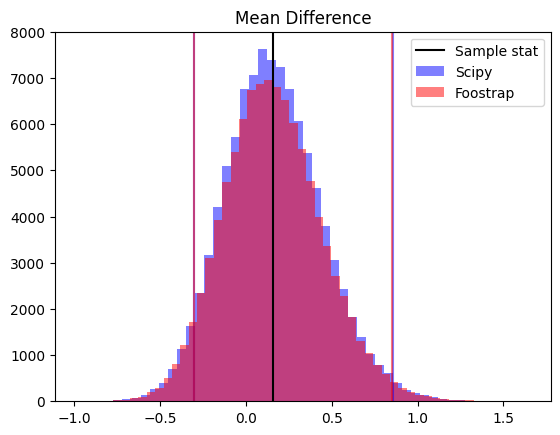

Scipy CI:  -0.016000000000000014 0.05499999999999999
Foostrap CI:  -0.015999999999999986 0.055999999999999994


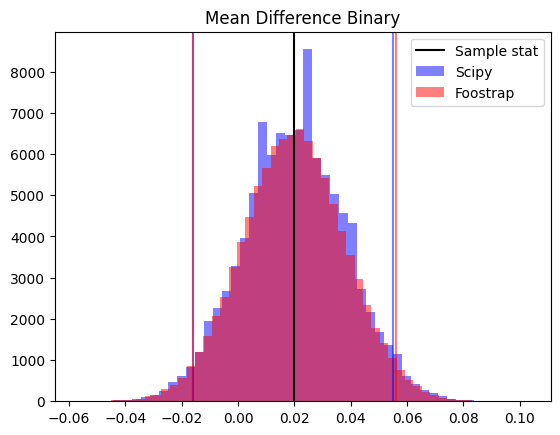

Scipy CI:  3.924932602900227 15.42012614171195
Foostrap CI:  3.9331950069120802 15.472428473856793


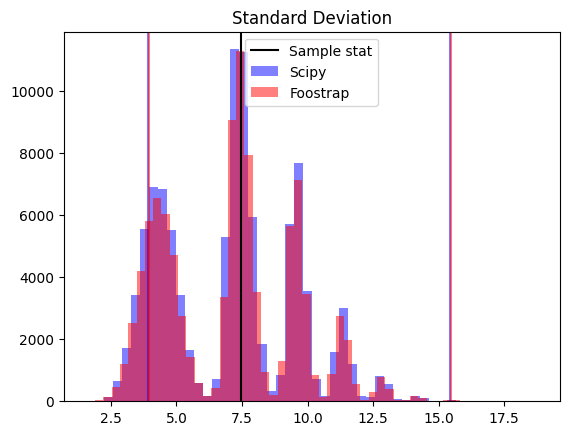

Scipy CI:  0.8631871979993262 2.0452075565105705
Foostrap CI:  0.8535454487547577 1.969899125314966


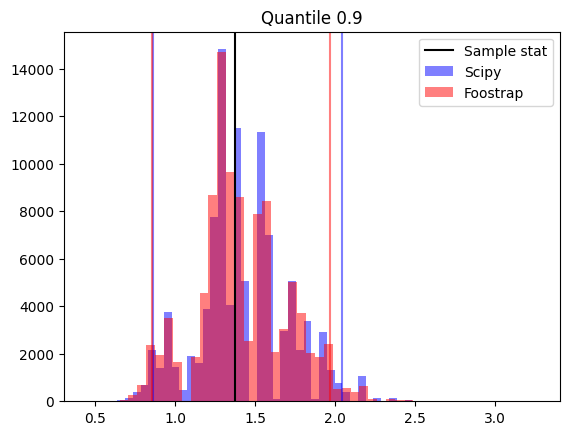

Scipy CI:  -0.08501041414806597 0.11532336924935756
Foostrap CI:  -0.08522994805997042 0.11558134639224603


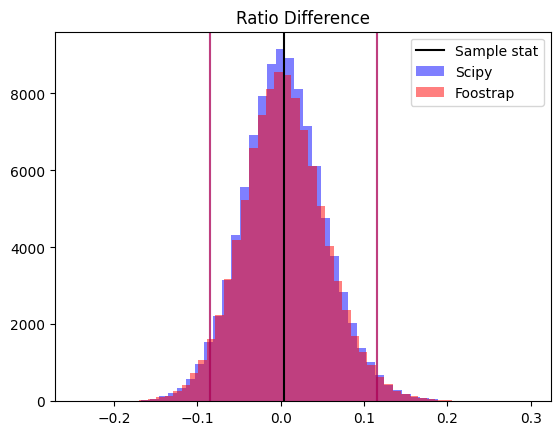

Scipy CI:  -1.7413208674840732 1.2775967100468437
Foostrap CI:  -1.7705770218782093 1.2731229814209173


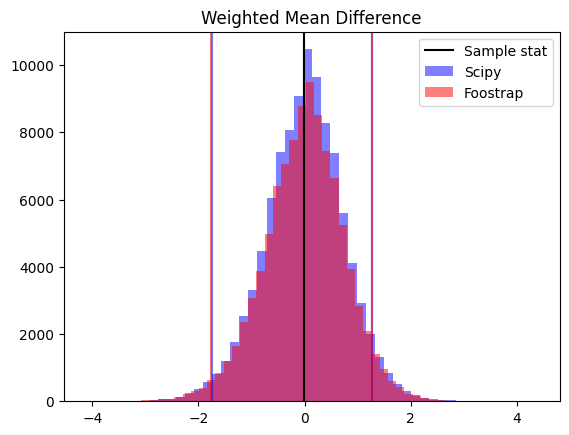

Scipy CI:  0.5320062935146672 0.8476985603675755
Foostrap CI:  0.5510591769889733 0.8480388343982307


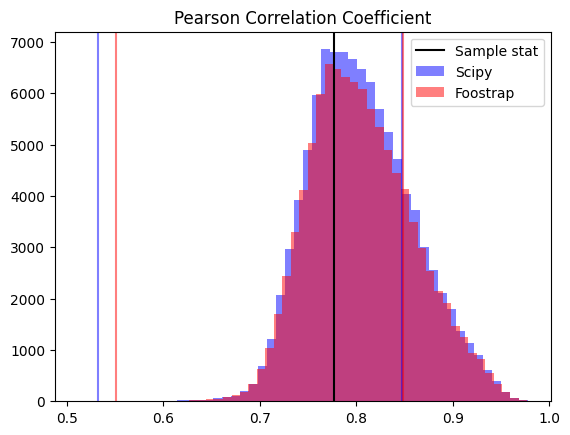

In [6]:
def plot_func(xs, xf, cis, cif, stat_val, stat_name):
    print('Scipy CI: ', cis[0], cis[1])
    print('Foostrap CI: ', cif[0], cif[1])
    plt.hist(xs, bins= 50, color= (0,0,1,0.5))
    plt.hist(xf, bins= 50, color= (1,0,0,0.5))
    plt.axvline(stat_val, color = (0,0,0,1))
    plt.legend(['Sample stat','Scipy','Foostrap'])
    plt.axvline(cis[0], color = (0,0,1,0.5))
    plt.axvline(cis[1], color = (0,0,1,0.5))
    plt.axvline(cif[0], color = (1,0,0,0.5))
    plt.axvline(cif[1], color = (1,0,0,0.5))
    plt.title(stat_name)
    plt.show()

ci_df = res[['ci lo','ci up']].apply(lambda r : tuple(r), axis= 1).unstack('lib')
samples_df = res.samples.unstack('lib')

stat = x.mean() - y.mean()
stat_name = 'Mean Difference'
loc = ('mean diff',2,'sparse',True)
plot_func(samples_df.scipy.loc[loc], samples_df.foostrap.loc[loc], ci_df.scipy.loc[loc], ci_df.foostrap.loc[loc], stat, stat_name)

stat = xb.mean() - yb.mean()
stat_name = 'Mean Difference Binary'
loc = ('mean diff',2,'binary',True)
plot_func(samples_df.scipy.loc[loc], samples_df.foostrap.loc[loc], ci_df.scipy.loc[loc], ci_df.foostrap.loc[loc], stat, stat_name)

stat = x.std()
stat_name = 'Standard Deviation'
loc = ('std dev',1,'sparse',True)
plot_func(samples_df.scipy.loc[loc], samples_df.foostrap.loc[loc], ci_df.scipy.loc[loc], ci_df.foostrap.loc[loc], stat, stat_name)

stat = np.quantile(x, 0.9)
stat_name = 'Quantile 0.9'
loc = ('quantile 0.9',1,'sparse',True)
plot_func(samples_df.scipy.loc[loc], samples_df.foostrap.loc[loc], ci_df.scipy.loc[loc], ci_df.foostrap.loc[loc], stat, stat_name)

stat = z.sum(axis=0)[0] / z.sum(axis=0)[1] - w.sum(axis=0)[0] / w.sum(axis=0)[1]
stat_name = 'Ratio Difference'
loc = ('ratio diff',2,'dense',True)
plot_func(samples_df.scipy.loc[loc], samples_df.foostrap.loc[loc], ci_df.scipy.loc[loc], ci_df.foostrap.loc[loc], stat, stat_name)

stat = z.prod(axis= 1).sum() / z[:,1].sum() - w.prod(axis= 1).sum() / w[:,1].sum()
stat_name = 'Weighted Mean Difference'
loc = ('w mean diff',2,'dense',True)
plot_func(samples_df.scipy.loc[loc], samples_df.foostrap.loc[loc], ci_df.scipy.loc[loc], ci_df.foostrap.loc[loc], stat, stat_name)

stat = pearson(xc[:,0], xc[:,1])
stat_name = 'Pearson Correlation Coefficient'
loc = ('pearson',1,'dense',True)
plot_func(samples_df.scipy.loc[loc], samples_df.foostrap.loc[loc], ci_df.scipy.loc[loc], ci_df.foostrap.loc[loc], stat, stat_name)